# Lab 7: Hierarchical Agglomerative Text Clustering (HAC / AGNES)

This notebook implements **Hierarchical Agglomerative Clustering (HACL)** for a Twitter text dataset, following the lab instructions:

1. Load the tweets
2. Preprocess text (tokenization, lemmatization, stopword removal, etc.)
3. Compute the term–document matrix (TF‑IDF)
4. Compute distance matrix
5. Perform Hierarchical Agglomerative Clustering
6. Draw the dendrogram
7. Interpret clustering
8. Compare clusters with existing class labels


In [2]:
%pip install nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [nltk]3/4 [nltk]]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akashmalik/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akashmalik/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akashmalik/nltk_data...


True

## 1. Load the Tweets Dataset

👉 **Note:** Replace `tweets_3class.csv` with your actual file name / path.
The dataset is expected to have at least:
- a text column (e.g. `text` or `tweet`)
- a label column (e.g. `label` or `class`)


In [4]:
# TODO: change file name if needed
df = pd.read_csv('tweets_3class.csv')  # <-- replace with your dataset filename

print(df.head())
print("\nColumns:", df.columns.tolist())


   0  s906201955755810819  \
0  1  s902344270245453824   
1  0  s821818682036879362   
2  0  s632172294517968896   
3  1  s651536433908465665   
4  0  s884717405850742785   

    That's a question for the Gov, but as you can see FL wil…   
0  Update: Collision; highway WB: at Exit194, no ...            
1  SNAP E&amp;T Learning Academy builds national ...            
2   What Do You Mean? Taking it worldwide . #14Days             
3  Disabled Vehicle on Northbound highway NB at M...            
4  Direct hit! See how our #THAAD system intercep...            

Columns: ['0', 's906201955755810819', "  That's a question for the Gov, but as you can see FL wil… "]


Set the names of the **text column** and **label column** here so that the rest of the notebook works with your dataset.

In [6]:
# Set these to match your dataset
TEXT_COL = 'text'   # e.g. 'text', 'tweet'
LABEL_COL = 'label' # e.g. 'label', 'class'

# Rename columns to match expected names
df.columns = [LABEL_COL, 'id', TEXT_COL]

texts = df[TEXT_COL].astype(str).values
labels_raw = df[LABEL_COL].astype(str).values

print("Number of samples:", len(texts))
print("Unique labels:", np.unique(labels_raw))


Number of samples: 10220
Unique labels: ['0' '1']


## 2. NLP Pre‑processing

- Lower‑casing
- Removing URLs, mentions, hashtags, digits, punctuation
- Tokenization
- Stopword removal
- Lemmatization


In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet(text: str) -> str:
    # lower case
    text = text.lower()
    # remove urls
    text = re.sub(r'http\S+|www\S+', ' ', text)
    # remove mentions and hashtags
    text = re.sub(r'[@#]\w+', ' ', text)
    # keep only letters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # tokenize using regex to avoid requiring NLTK punkt tokenizer
    tokens = re.findall(r'\b[a-z]{3,}\b', text)
    # remove stopwords then lemmatize
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens
              if tok not in stop_words]
    return ' '.join(tokens)

clean_texts = [clean_tweet(t) for t in texts]
df['clean_text'] = clean_texts
df[['clean_text', LABEL_COL]].head()


,clean_text,label
0,update collision highway exit lns clsd ocrd,1
1,snap amp learning academy build national leade...,0
2,mean taking worldwide,0
3,disabled vehicle northbound highway mile marker,1
4,direct hit see system intercepted missile targ...,0


## 3. Term‑Document Matrix (TF‑IDF)


In [9]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(clean_texts)
X_tfidf.shape


(10220, 5000)

## 4. Distance Matrix (Cosine Distance)

We compute pairwise cosine distances on the TF‑IDF vectors.

In [10]:
# condensed distance matrix required for linkage/dendrogram
distance_matrix = pdist(X_tfidf.toarray(), metric='cosine')
distance_matrix.shape

(52219090,)

## 5. Perform Hierarchical Agglomerative Clustering

We start with each tweet as its own cluster, and iteratively merge closest clusters
using a chosen **linkage** criterion (e.g. `average`, `complete`, `single`, `ward`).


In [12]:
linkage_method = 'average'  # try 'single', 'complete', 'ward' too (ward needs euclidean)

# Remove non-finite values from distance matrix
distance_matrix_clean = distance_matrix[np.isfinite(distance_matrix)]

Z = linkage(distance_matrix_clean, method=linkage_method)
Z[:5]


array([[0.0000e+00, 2.9760e+03, 0.0000e+00, 2.0000e+00],
       [2.2320e+03, 3.9200e+03, 0.0000e+00, 2.0000e+00],
       [6.7160e+03, 1.0216e+04, 0.0000e+00, 3.0000e+00],
       [5.1070e+03, 5.5330e+03, 0.0000e+00, 2.0000e+00],
       [5.4120e+03, 8.0470e+03, 0.0000e+00, 2.0000e+00]])

## 6. Draw the Dendrogram


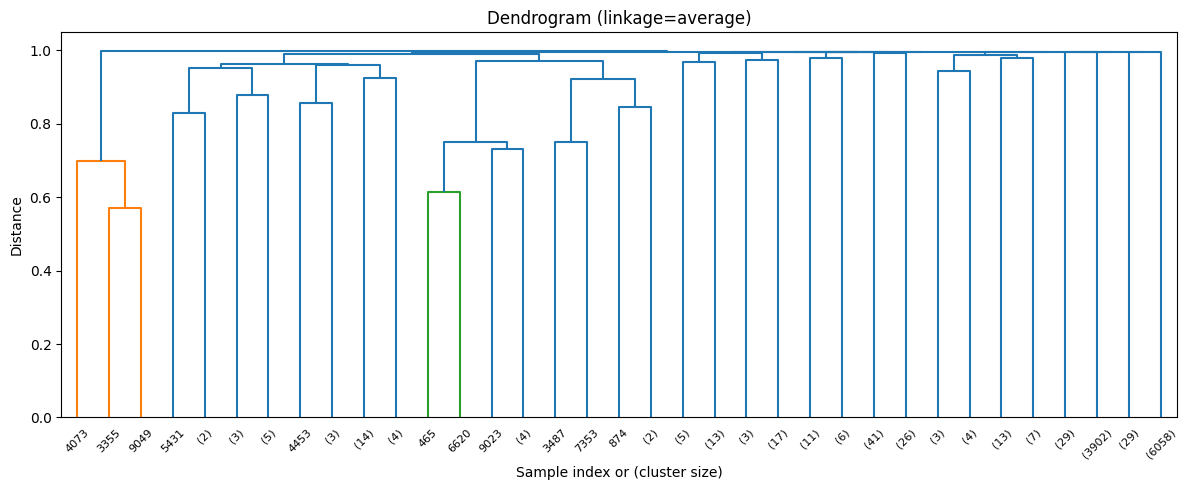

In [13]:
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title(f'Dendrogram (linkage={linkage_method})')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


## 7. Cut the Dendrogram into k Clusters and Interpret

We now choose a number of clusters `k` (e.g. 3 classes as mentioned in the lab) and
obtain cluster labels.  We then compare them to the true labels in the dataset.


In [15]:
from scipy.cluster.hierarchy import fcluster

k = 3  # number of target clusters (change if needed)
cluster_labels = fcluster(Z, k, criterion='maxclust')

# Ensure the dataframe matches the length of cluster_labels
df = df.iloc[:len(cluster_labels)].copy()
df['cluster'] = cluster_labels
df[[TEXT_COL, 'clean_text', LABEL_COL, 'cluster']].head()


,text,clean_text,label,cluster
0,"Update: Collision; highway WB: at Exit194, no ...",update collision highway exit lns clsd ocrd,1,3
1,SNAP E&amp;T Learning Academy builds national ...,snap amp learning academy build national leade...,0,3
2,What Do You Mean? Taking it worldwide . #14Days,mean taking worldwide,0,3
3,Disabled Vehicle on Northbound highway NB at M...,disabled vehicle northbound highway mile marker,1,3
4,Direct hit! See how our #THAAD system intercep...,direct hit see system intercepted missile targ...,0,3


## 8. Compare Clusters with Existing Class Labels

We use:
- Confusion matrix
- Adjusted Rand Index (ARI)
- Silhouette score (internal clustering quality)


Confusion Matrix (rows=true, cols=cluster):
[[   0    2   26 5078]
 [   0    1   19 5089]
 [   0    0    0    0]
 [   0    0    0    0]]

Adjusted Rand Index (higher better, 0=random): 1.2745962848300613e-06
Silhouette score (higher better): -0.0018463472723247347


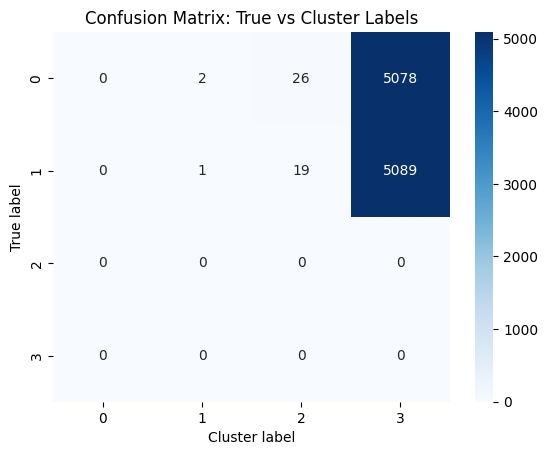

In [17]:
# Encode true labels as integers for comparison
# Use the dataframe `df` which was trimmed to match cluster_labels length (see cell 17)
le = LabelEncoder()
y_true = le.fit_transform(df[LABEL_COL].astype(str).values)
y_cluster = cluster_labels

# Trim X_tfidf to the same number of samples as cluster_labels
n = len(y_cluster)
X_tfidf_trim = X_tfidf[:n]

cm = confusion_matrix(y_true, y_cluster)
ari = adjusted_rand_score(y_true, y_cluster)
sil = silhouette_score(X_tfidf_trim, y_cluster, metric='cosine')

print('Confusion Matrix (rows=true, cols=cluster):')
print(cm)
print('\nAdjusted Rand Index (higher better, 0=random):', ari)
print('Silhouette score (higher better):', sil)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Cluster label')
plt.ylabel('True label')
plt.title('Confusion Matrix: True vs Cluster Labels')
plt.show()


## 9. Simple Cluster Interpretation

To interpret each cluster, we can look at a few example tweets from each cluster
and also show the top TF‑IDF terms for that cluster.


In [18]:
feature_names = np.array(vectorizer.get_feature_names_out())

for c in range(1, k+1):
    print(f"\n=== Cluster {c} ===")
    idx = np.where(cluster_labels == c)[0]
    print(f"Number of tweets: {len(idx)}")
    
    # Show a few example tweets
    for t in df.iloc[idx][:3][TEXT_COL]:
        print("-", t)
    
    # Compute mean TF-IDF for this cluster and get top terms
    mean_tfidf = X_tfidf[idx].mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[::-1][:10]
    print("Top terms:", feature_names[top_idx])



=== Cluster 1 ===
Number of tweets: 3
- The cum whores are out this weekend. BE careful
- Emergency Closure: R64712 UPDATED: EGLINTON AVE E From MCCOWAN RD To TORRANCE RD. Update: West bound lanes... 
-  Hi Michael, pls DM your stay info. We would like to share your positive feedback with htl mgmt.
Top terms: ['cum' 'careful' 'eglinton' 'weekend' 'mgmt' 'emergency' 'michael'
 'positive' 'bound' 'pls']

=== Cluster 2 ===
Number of tweets: 45
- VP Mike Pence Rolls Up Sleeves Alongside Franklin Graham to Help Harvey Victims 
- Great news! WSDOT Maintenance crews made quick work of the sinkhole on SR . Both directions are back open. Permanent repair plan to come.
-  Hey Vipin. You can learn about the shop section on Facebook here: Thanks! -CB
Top terms: ['cleared' 'construction' 'highway' 'exit' 'north' 'updated' 'lane'
 'blocked' 'amp' 'northbound']

=== Cluster 3 ===
Number of tweets: 10167
- Update: Collision; highway WB: at Exit194, no lns clsd, Ocrd: // :19AM.| :36P
- SNAP E&amp;T Le